# Model Selection - ABC

In [110]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings, ProgressMeter
pyplot()

Plots.PyPlotBackend()

#### **Auxiliary Functions**

Sample from Triangular Uniform 

In [94]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end;

Moving Averge Functions

In [95]:
MA2(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA2(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA2.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

MA1(current, u,t) = u[current+1] + u[current] * t[1]

function genMA1(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA1.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end;

AutoCovariance

In [96]:
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end
autocov_vectorize(z)    = abcautocov_distance(y,z);

Likelihood for Moving Average 

In [97]:
function Ger_SimgaM2(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

function Ger_SimgaM1(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 2
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 99
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        elseif i == 100
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
        else
            Σ[i,i-1] = θ1
            Σ[i,i]   = 1 + θ1^2
            Σ[i,i+1] = θ1
        end
    end

    return Σ
    end;

## **Model Choice for MA(2)**

#### Synthetic Data

In [99]:
using Random
Random.seed!(3)
theta = [0.6;0.38]
n     = 100
u     = randn(n+2)
y     = MA2.((1:n),Ref(u),Ref(theta));

#### Contour Plot

In [100]:
# Contour Plot - True posterior
gθ1      = 0:0.02:1
gθ2      = -0.5:0.02:0.8
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvnM2(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM2(θ1,θ2,y)),y)
mamvnM1(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM1(θ1,θ2,y)),y);

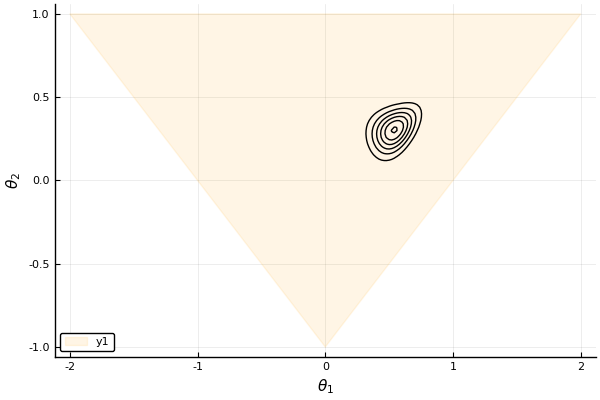

In [101]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
p1 = contour!(gθ1,gθ2, mamvnM2, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

#### Real Bayes Factor
Let's consider that $P(M_1) = P(M_2) = 0.5$, then:
$$
\frac{P(M_2 \mid y)}{P(M_1 \mid y)} = \frac{P(y \mid M_2)P(M_2)}{P(y \mid M_1)P(M_1)} =
\frac{P(y \mid M_2)}{P(y \mid M_1)} =
\frac{\int \int P(y, \theta_1, \theta_2 \mid M_2)d\theta_1d\theta_2}
{\int P(y, \theta_1 \mid M_1)d\theta_1}=
\frac{\int \int P(y \mid \theta_1, \theta_2, M_2)\pi(\theta_1,\theta_2 \mid M_2)d\theta_1d\theta_2}
{\int P(y \mid \theta_1, M_1)\pi(\theta_1 \mid M_1)d\theta_1}
$$

Since,
$$\pi(\theta_1,\theta_2 \mid M_2) = \frac{1}{4} \unicode{x1D7D9}_{1+\theta_1^2 + \theta_2^2 \leq 1}$$
$$\pi(\theta_1 \mid M_1) = \frac{1}{2} \unicode{x1D7D9}_{\theta_1^2\leq 1}$$


In [102]:
Ns = 20_000
# Z = mamvnM2.(rand(Ns),rand(Ns) .- 0.5)
Z = mamvnM2.(rand(Ns),rand(Ns))
ZM2 = sum(Z)/Ns
ZM1 = sum(mamvnM1.(rand(Ns),0))/Ns

1.4049039649715063e-60

In [103]:
BF = (ZM2/4)/(ZM1/2)
PM2= (BF)/(1+BF)
PM1= 1-(BF)/(1+BF)
BF,PM2,PM1

(20.024637574860527, 0.9524367544296832, 0.04756324557031677)

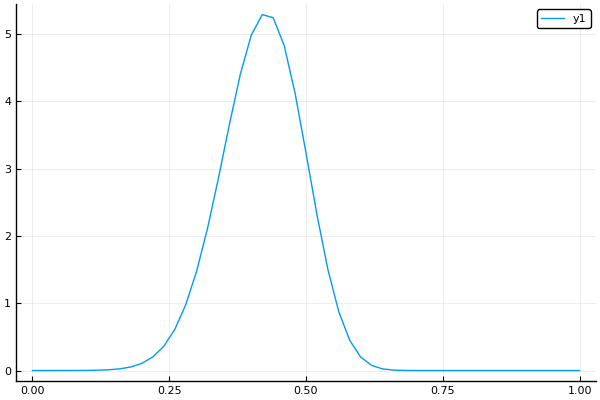

In [104]:
plot(gθ1,exp.(log.(mamvnM1.(gθ1,0)) .- log(ZM1)))

## ABC Model Choice

In [105]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_ms= rand_TriUniform(N)
u       = randn(N,n+2)
zm2     = genMA2(u,theta_ms,n,N);

rho_M2 = mapslices(autocov_vectorize, zm2, dims =2)[:];
epsilon_M2 = quantile.(Ref(rho_M2[:]),[10,1,0.1,0.01]./100)

4-element Array{Float64,1}:
 1646.3143643043277   
  159.60357868913658  
   16.69488584408776  
    1.5864534323687307

In [114]:
function ModelChoiceABC(ϵ,Nm=100)
    mi = zeros(Nm)
    θM = zeros(Nm,2)
    p = Progress(Nm)
    for i = 1:Nm
        M = 0
        θm= [0.,0.]
        ρ = ϵ*2
        while ρ > ϵ
            M  = rand(1:2)
            u  = randn(n+2)
            if M == 1
                θm = rand(2).*2 .-1
                zm = MA1.((1:n),Ref(u),Ref(θm));
            else
                θm = rand_TriUniform(1)
                zm = MA2.((1:n),Ref(u),Ref(θm));
            end
            ρ = abcautocov_distance(y,zm)
        end 
        mi[i]   = M
        θM[i,:] = θm
        next!(p)
    end
    return mi,θM
end

ModelChoiceABC (generic function with 2 methods)

In [115]:
pM2= zeros(length(epsilon_M2),2)
Nm = 10_00
results = ModelChoiceABC.(epsilon_M2,Nm)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


4-element Array{Tuple{Array{Float64,1},Array{Float64,2}},1}:
 ([1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0  …  2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0], [0.486004 0.463041; 0.213116 0.604234; … ; 0.837499 0.686166; 0.207513 0.387548])
 ([1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0], [0.338457 -0.896507; 0.234195 0.710696; … ; 0.428964 0.47465; 0.531046 0.462202])
 ([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0], [0.642788 0.717269; 0.510782 0.22728; … ; 0.563296 0.425618; 0.532758 0.651945]) 
 ([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0], [0.381189 0.27235; 0.409561 0.0255978; … ; 0.206598 0.398155; 0.552005 0.455601])

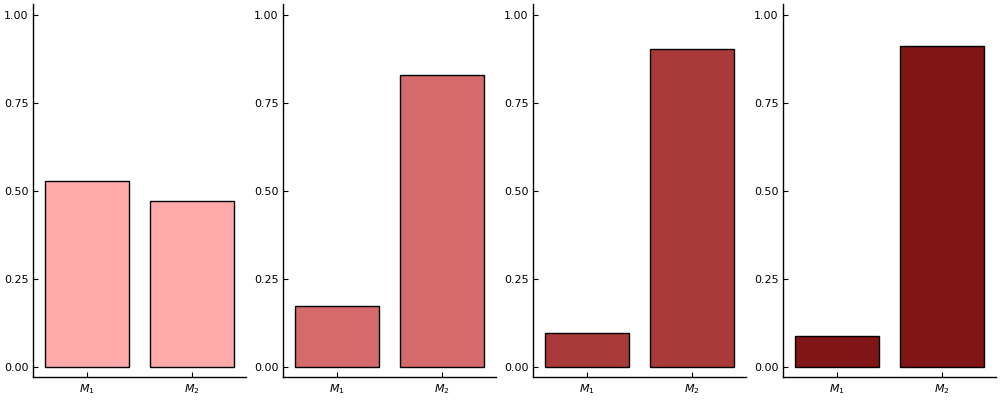

In [116]:
for i = 1:length(epsilon_M2)
    pM2[i,2] = sum(results[i][1] .== 2)/Nm
    pM2[i,1] = 1-sum(results[i][1] .== 2)/Nm
end
xbar = [L"M_1",L"M_2"]
colorsbar = ["#FFAAAA","#D46A6A","#AA3939","#801515"]
b = []
for i = 1:4
    push!(b,bar(xbar,pM2[i,:],fillcolor=colorsbar[i],ylims=[0,1],legend=false,grid=false))
end 
plot(b[1],b[2],b[3],b[4],layout=(1,4),size=(1000,400))

## **Model Choice for MA(1)**

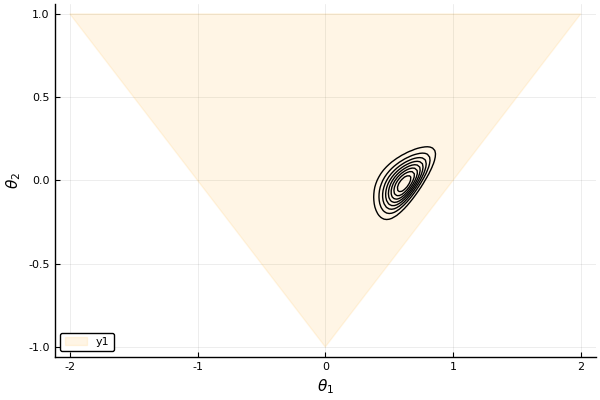

In [47]:
Random.seed!(3)
theta = [0.6;0.0]
n     = 100
u     = randn(n+2)
y     = MA1.((1:n),Ref(u),Ref(theta));

# Contour Plot - True posterior
gθ1      = 0:0.02:1
gθ2      = -0.5:0.02:0.8
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvnM2(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM2(θ1,θ2,y)),y)
mamvnM1(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_SimgaM1(θ1,θ2,y)),y);

plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
p1 = contour!(gθ1,gθ2, mamvnM2, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

#### Real Bayes Factor

In [48]:
Ns = 20_000
# Z = mamvnM2.(rand(Ns),rand(Ns) .- 0.5)
Z = mamvnM2.(rand(Ns),rand(Ns))
ZM2 = sum(Z)/Ns
ZM1 = sum(mamvnM1.(rand(Ns),0))/Ns

BF = (ZM2/4)/(ZM1/2)
PM2= (BF)/(1+BF)
PM1= 1-(BF)/(1+BF)
BF,PM2,PM1

(0.06018138911093881, 0.05676518162746332, 0.9432348183725366)

#### ABC Model Choice

In [49]:
N = 10^6        # number of trials
n = length(y) # sample size
theta_ms= rand_TriUniform(N)
u       = randn(N,n+2)
zm2     = genMA2(u,theta_ms,n,N);

rho_M1 = mapslices(autocov_vectorize, zm2, dims =2)[:];
epsilon_M2 = quantile.(Ref(rho_M2[:]),[10,1,0.1,0.01]./100);

In [53]:
pM1= zeros(length(epsilon_M2),2)
Nm = 10_000
results = ModelChoiceABC.(epsilon_M2,Nm)

4-element Array{Tuple{Array{Float64,1},Array{Float64,2}},1}:
 ([1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.198905 0.794907; 0.736012 0.51712; … ; 0.731954 0.444089; 0.91408 0.363856])      
 ([1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0], [0.401471 -0.409838; 0.484326 0.107593; … ; 0.584755 -0.637845; 0.693711 -0.0928768])
 ([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0], [0.421837 -0.540495; 0.382257 0.910262; … ; 0.590289 0.49086; 0.360788 -0.0268669])  
 ([2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0], [0.550012 0.113906; 0.431069 -0.498046; … ; 0.23792 -0.403302; 0.29439 0.801665])    

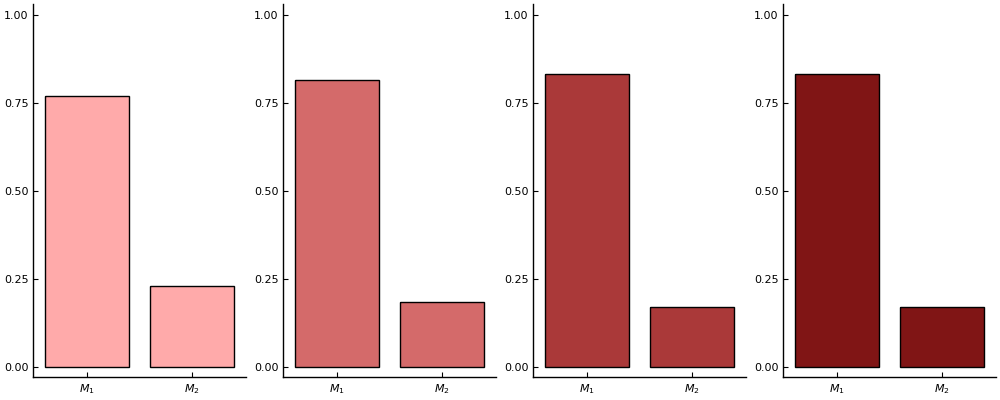

In [81]:
for i = 1:length(epsilon_M2)
    pM1[i,2] = sum(results[i][1] .== 2)/Nm
    pM1[i,1] = 1-sum(results[i][1] .== 2)/Nm
end
xbar = [L"M_1",L"M_2"]
colorsbar = ["#FFAAAA","#D46A6A","#AA3939","#801515"]
b = []
for i = 1:4
#     h = hline([0.943],xlims=[1,4])
#     annotate!([(1.5,0.97,"Real")])
    push!(b,bar(xbar,pM1[i,:],fillcolor=colorsbar[i],ylims=[0,1],legend=false,grid=false))
end 
plot(b[1],b[2],b[3],b[4],layout=(1,4),size=(1000,400))

In [55]:
pM1

4×2 Array{Float64,2}:
 0.7695  0.2305
 0.8146  0.1854
 0.8302  0.1698
 0.8307  0.1693